In [7]:
# !pip install plotly
# !pip install pandas
import pandas as pd
# !pip install pandas_ta
# import pandas_ta as ta
import numpy as np
# !pip install seaborn
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree

from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

# Creating DataFrame

In [8]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



08-10-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-08-10,306.826433,4.116430e+08,306.826433,NaN,NaN,NaN,NaN,NaN
2017-08-11,308.625531,4.854745e+08,308.225732,1.799098,NaN,NaN,NaN,NaN
2017-08-12,297.159803,6.890798e+08,300.132739,-11.465729,NaN,NaN,NaN,NaN
2017-08-13,296.397290,3.844787e+08,297.446661,-0.762513,NaN,NaN,NaN,NaN
2017-08-14,288.450767,5.269512e+08,291.008765,-7.946522,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-08-05,1725.382627,1.771748e+10,1694.317005,112.963720,64.132421,91.906803,-1.020664,92.927467
2022-08-06,1693.296592,1.123110e+10,1693.588139,-32.086035,61.299474,90.507359,-1.936087,92.443446
2022-08-07,1699.006418,9.464716e+09,1697.458338,5.709826,61.624313,88.834990,-2.886765,91.721754


In [9]:
mydf.dropna(inplace=True)
myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [10]:
my_data = mydf[myCols]
# display(my_data.tail(10))
my_data.drop(my_data.tail(10).index,
        inplace = True)
display(my_data)

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,macd_h,macd_s,ethereum_diff
date,,,,,,,,
2017-09-12,277.333658,7.217389e+08,281.583371,36.459164,-8.656418,-7.258044,-1.398375,-13.252874
2017-09-13,214.311714,9.298616e+08,233.532187,25.453502,-15.482216,-11.267073,-4.215143,-63.021944
2017-09-14,246.921857,1.617180e+09,243.096237,36.187729,-18.052249,-11.069685,-6.982564,32.610144
2017-09-15,244.805612,5.862583e+08,244.317219,35.826553,-20.028901,-10.437070,-9.591832,-2.116246
2017-09-16,249.666546,3.364445e+08,248.138167,37.369767,-20.961544,-9.095770,-11.865774,4.860934
...,...,...,...,...,...,...,...,...
2022-07-26,1438.988038,1.771199e+10,1453.382267,54.248585,73.668397,18.962187,54.706210,-11.494247
2022-07-27,1636.949181,2.279256e+10,1584.501492,63.905239,83.037922,22.665370,60.372552,197.961143
2022-07-28,1723.548521,2.750825e+10,1683.820798,67.169773,96.340627,28.774460,67.566167,86.599339


# sliding window

### train test split and create sliding window

In [11]:
seq=list(mydf['ethereum'])
# display(seq)
scaler = StandardScaler()
window_size = 15
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)

sliding_df = sliding_df.drop(columns=[1,2,3,4,5])
display(sliding_df)
y = sliding_df[14]
X = sliding_df.drop(columns=[14]) 
X=scaler.fit_transform(X)
# print('X')
# display(X)
# print('y')
# display(y)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train = X[:-360]
X_test = X[-360:]
y_train = y[:-360]
y_test = y[-360:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


,0,6,7,8,9,10,11,12,13,14
0,277.333658,280.445632,279.417649,257.465074,263.469774,283.222159,280.681045,288.085701,283.929453,302.151845
1,214.311714,279.417649,257.465074,263.469774,283.222159,280.681045,288.085701,283.929453,302.151845,294.313838
2,246.921857,257.465074,263.469774,283.222159,280.681045,288.085701,283.929453,302.151845,294.313838,288.114597
3,244.805612,263.469774,283.222159,280.681045,288.085701,283.929453,302.151845,294.313838,288.114597,297.268936
4,249.666546,283.222159,280.681045,288.085701,283.929453,302.151845,294.313838,288.114597,297.268936,299.674889
...,...,...,...,...,...,...,...,...,...,...
1774,1536.124922,1723.548521,1739.042177,1696.785098,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627
1775,1552.496489,1739.042177,1696.785098,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627,1693.296592
1776,1601.207967,1696.785098,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627,1693.296592,1699.006418
1777,1450.482285,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627,1693.296592,1699.006418,1775.701356


X_train: 
(1419, 9)
X_test: 
(360, 9)
y_train: 
(1419,)
y_test: 
(360,)


### xgboost on sliding window

Root Mean squared error train: 356.16
Root Mean squared error test: 1351.76
r2_score train:  0.7698595100271313
r2_score test:  -0.8769581964558206


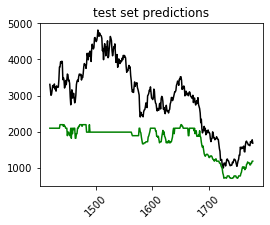

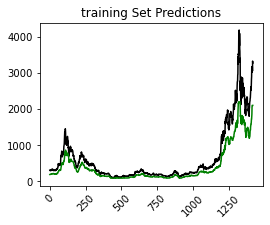

In [12]:

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
y_pred_test=xg_reg.predict(X_test)
y_pred_train=xg_reg.predict(X_train)
# rmse=np.sqrt(mean_squared_error(y_test,preds))
# print(preds)
# print(y_check1)
# print('xgb rmse: ', rmse)

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))


y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(4, 3))
plt.plot(y_testc.index,y_testc[14], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(4, 3))
plt.plot(y_trainc.index,y_trainc[14], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

## hyperparameter tuning on sliding windows feature set

In [13]:
parameters = {
    'max_depth': range (2, 10, 1),
    'booster': ['gbtree', 'gblinear'],
#     'n_estimators': range(0, 1000, 50),
    'n_estimators': [10,50,60,200,500,1000],
    'learning_rate': [0.1, 0.01, 0.05]
#     'eval_metric': ['rmse', 'mae', 'mape']
}
grid_search = GridSearchCV(
    estimator=xg_reg,
    param_grid=parameters,
#     scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=0.3,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.1, max_bin=256,
                                    max_...ta_step=0,
                                    max_depth=5, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=10,
                                    n_jobs=0, num_parallel_tree=1,
  

Root Mean squared error train: 41.22
Root Mean squared error test: 489.53
r2_score train:  0.9969171883021586
r2_score test:  0.7538427347441758


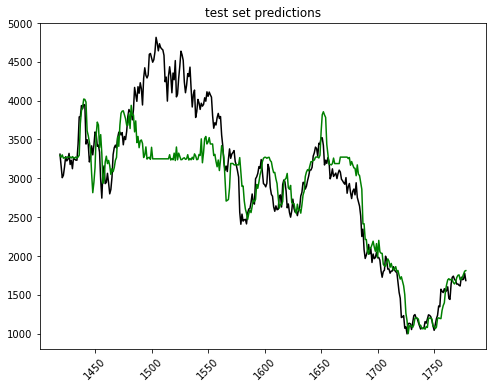

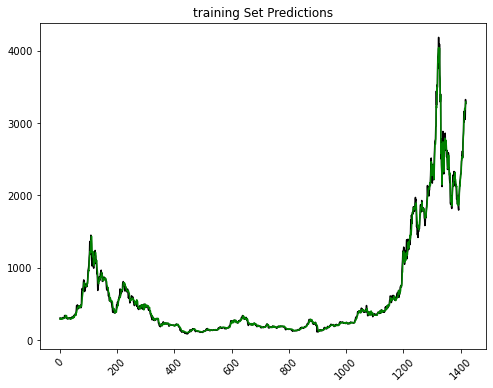

In [14]:
grid_search.best_estimator_
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)
y_pred_train = grid_search.best_estimator_.predict(X_train)
# rmse=np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))

y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(8, 6))
plt.plot(y_testc.index,y_testc[14], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(8, 6))
plt.plot(y_trainc.index,y_trainc[14], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

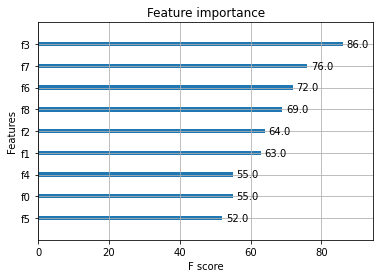

In [15]:
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize']=[16,10]
plt.show()

# linear regression on sliding window

Root Mean squared error train: 58.00
Root Mean squared error test: 136.09
r2_score train:  0.9938958273702974
r2_score test:  0.980976860483858
adjusted r2_score test: 0.9804876940391573


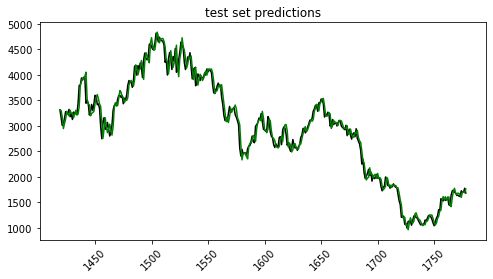

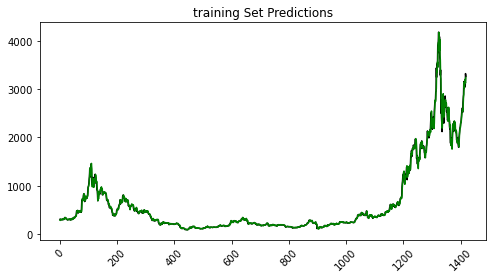

In [16]:
# print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)
# The mean squared error
# print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))
print('adjusted r2_score test:', 1-(1-r2_score(y_test, y_pred_test))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(8, 4))
plt.plot(y_testc.index,y_testc[14], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(8, 4))
plt.plot(y_trainc.index,y_trainc[14], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

In [17]:
print('hi')

hi
